In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import proplot as pplt
import xarray
#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

d:\Miniconda3\envs\guteEnv\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#############################################################
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
Xanthos_grid_areas = np.array(pd.read_csv(dir_in + '/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')

n_basin = GRDC_xanthosCoordIndx.shape[0]
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = [basinName['Basin_Name'][basins94[ii] - 1] for ii in range(n_basin)]
reservoirs_halfDegree = xarray.open_dataset(dir_in + '/Xanthos_reservoirs_halfDegree_global.nc')

In [3]:
def data_seasonality(data_ts):
    mean_monthly = data_ts.groupby(data_ts.index.month).mean()
    mean_annual  = mean_monthly.sum()
    SI = np.sum(np.abs(mean_monthly - (mean_annual/12))) / mean_annual
    return np.array(SI)[0]

In [4]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

In [5]:
def data_CV(data_ts):
    _annual = data_ts.resample('A').mean()
    mean_annual = _annual.mean()
    std_annual  = _annual.std()
    cv_ = std_annual / mean_annual 

    return np.array(cv_)[0]

## Release

In [6]:

ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp = dir_in + '/Simulated/SimulatedFinal-HP/reservoirRelease/'
file_dir_fc = dir_in + '/Simulated/SimulatedFinal-FC/reservoirRelease/'
dir_usgrid = dir_in + '/UScells/contributing_grids_all'
nrmse_hpfc_all_release = None
for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[ppose_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'ReservoirsRelease_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'ReservoirsRelease_' + str(basin_num) + '.npy')   

    # compute KGE between the two
    nrmse_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    Qsi_fc  = np.zeros([indx_basin.shape[0],])
    Qsi_hp  = np.zeros([indx_basin.shape[0],])        
    Qcv_fc  = np.zeros([indx_basin.shape[0],])
    Qcv_hp  = np.zeros([indx_basin.shape[0],])  
    
    if indx_basin.shape[0] > 0:
        for ii in range(indx_basin.shape[0]):
            mm = indx_basin[ii]
            # with hydropower
            rsim_hp= data_basin_hp[mm,:]
            # with flood control
            rsim_fc= data_basin_fc[mm,:]
            #plt.show()
            nrmse_hpfc[ii] = spotpy.objectivefunctions.rmse(rsim_fc[0:240], rsim_hp[0:240])/np.mean(rsim_hp[0:240])
            r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_fc[0:240], rsim_hp[0:240])
            # SI
            Qsi_fc[ii] = data_seasonality(timeseries_coverter(rsim_fc[0:240], 1971, 1990))
            Qsi_hp[ii] = data_seasonality(timeseries_coverter(rsim_hp[0:240], 1971, 1990))
            # CV
            Qcv_fc[ii] = data_CV(timeseries_coverter(rsim_fc[0:240], 1971, 1990))
            Qcv_hp[ii] = data_CV(timeseries_coverter(rsim_hp[0:240], 1971, 1990))        


        nrmse_hpfc_df_release = pd.DataFrame()
        nrmse_hpfc_df_release['Lon'] = Lon_HP
        nrmse_hpfc_df_release['Lat'] = Lat_HP

        #kge_hpfc[kge_hpfc  < -1] = -1 #for colorbar purpose only
        nrmse_hpfc_df_release['NRMSE'] = nrmse_hpfc
        nrmse_hpfc_df_release['R2'] = r2_hpfc
        ###
        nrmse_hpfc_df_release['SIQfc'] = Qsi_fc
        nrmse_hpfc_df_release['SIQhp'] = Qsi_hp
        ###
        nrmse_hpfc_df_release['CVQfc'] = Qcv_fc
        nrmse_hpfc_df_release['CVQhp'] = Qcv_hp

        # capacity
        nrmse_hpfc_df_release['CAP'] = capac_HP

        if nrmse_hpfc_all_release is None:
            nrmse_hpfc_all_release = nrmse_hpfc_df_release
        else:
            nrmse_hpfc_all_release = pd.concat([nrmse_hpfc_all_release, nrmse_hpfc_df_release],0).reset_index(drop=True)


#### Storage 

In [7]:
# directory for reservoir release data
file_dir_hp = dir_in + '/Simulated/SimulatedFinal-HP/reservoir/'
file_dir_fc = dir_in + '/Simulated/SimulatedFinal-FC/reservoir/'
cc=0
nrmse_hpfc_all_storage = None
for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[ppose_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'SimReservoirs_' + str(basin_num) + '.npy')   
    if np.sum(data_basin_fc)==0:
        cc+=1

    # compute KGE between the two
    nrmse_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    Rsi_fc  = np.zeros([indx_basin.shape[0],])
    Rsi_hp  = np.zeros([indx_basin.shape[0],])   
    Rcv_fc  = np.zeros([indx_basin.shape[0],])
    Rcv_hp  = np.zeros([indx_basin.shape[0],])  
    if indx_basin.shape[0] > 0:
        for ii in range(indx_basin.shape[0]):
            mm = indx_basin[ii]
            # with hydropower
            rsim_hp= data_basin_hp[mm,:]*1e-6
            # with flood control
            rsim_fc= data_basin_fc[mm,:]*1e-6
            #plt.show()
            nrmse_hpfc[ii] = spotpy.objectivefunctions.rmse(rsim_fc[0:240], rsim_hp[0:240])/np.mean(rsim_hp[0:240])
            r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_fc[0:240], rsim_hp[0:240])
            # SI
            Rsi_fc[ii] = data_seasonality(timeseries_coverter(rsim_fc[0:240], 1971, 1990))
            Rsi_hp[ii] = data_seasonality(timeseries_coverter(rsim_hp[0:240], 1971, 1990))
            # CV
            Rcv_fc[ii] = data_CV(timeseries_coverter(rsim_fc[0:240], 1971, 1990))
            Rcv_hp[ii] = data_CV(timeseries_coverter(rsim_hp[0:240], 1971, 1990))        

        nrmse_hpfc_df_storage = pd.DataFrame()
        nrmse_hpfc_df_storage['Lon'] = Lon_HP
        nrmse_hpfc_df_storage['Lat'] = Lat_HP

        #nrmse_hpfc[kge_hpfc  <-1] = -1 #for colorbar purpose only
        nrmse_hpfc_df_storage['NRMSE'] = nrmse_hpfc
        nrmse_hpfc_df_storage['R2'] = r2_hpfc
        ###
        nrmse_hpfc_df_storage['SIRfc'] = Rsi_fc
        nrmse_hpfc_df_storage['SIRhp'] = Rsi_hp
        ###
        nrmse_hpfc_df_storage['CVRfc'] = Rcv_fc
        nrmse_hpfc_df_storage['CVRhp'] = Rcv_hp
        # capacity
        nrmse_hpfc_df_storage['CAP'] = capac_HP 
        if jj==0:
            nrmse_hpfc_all_storage = nrmse_hpfc_df_storage
        else:
            nrmse_hpfc_all_storage = pd.concat([nrmse_hpfc_all_storage, nrmse_hpfc_df_storage],0).reset_index(drop=True)

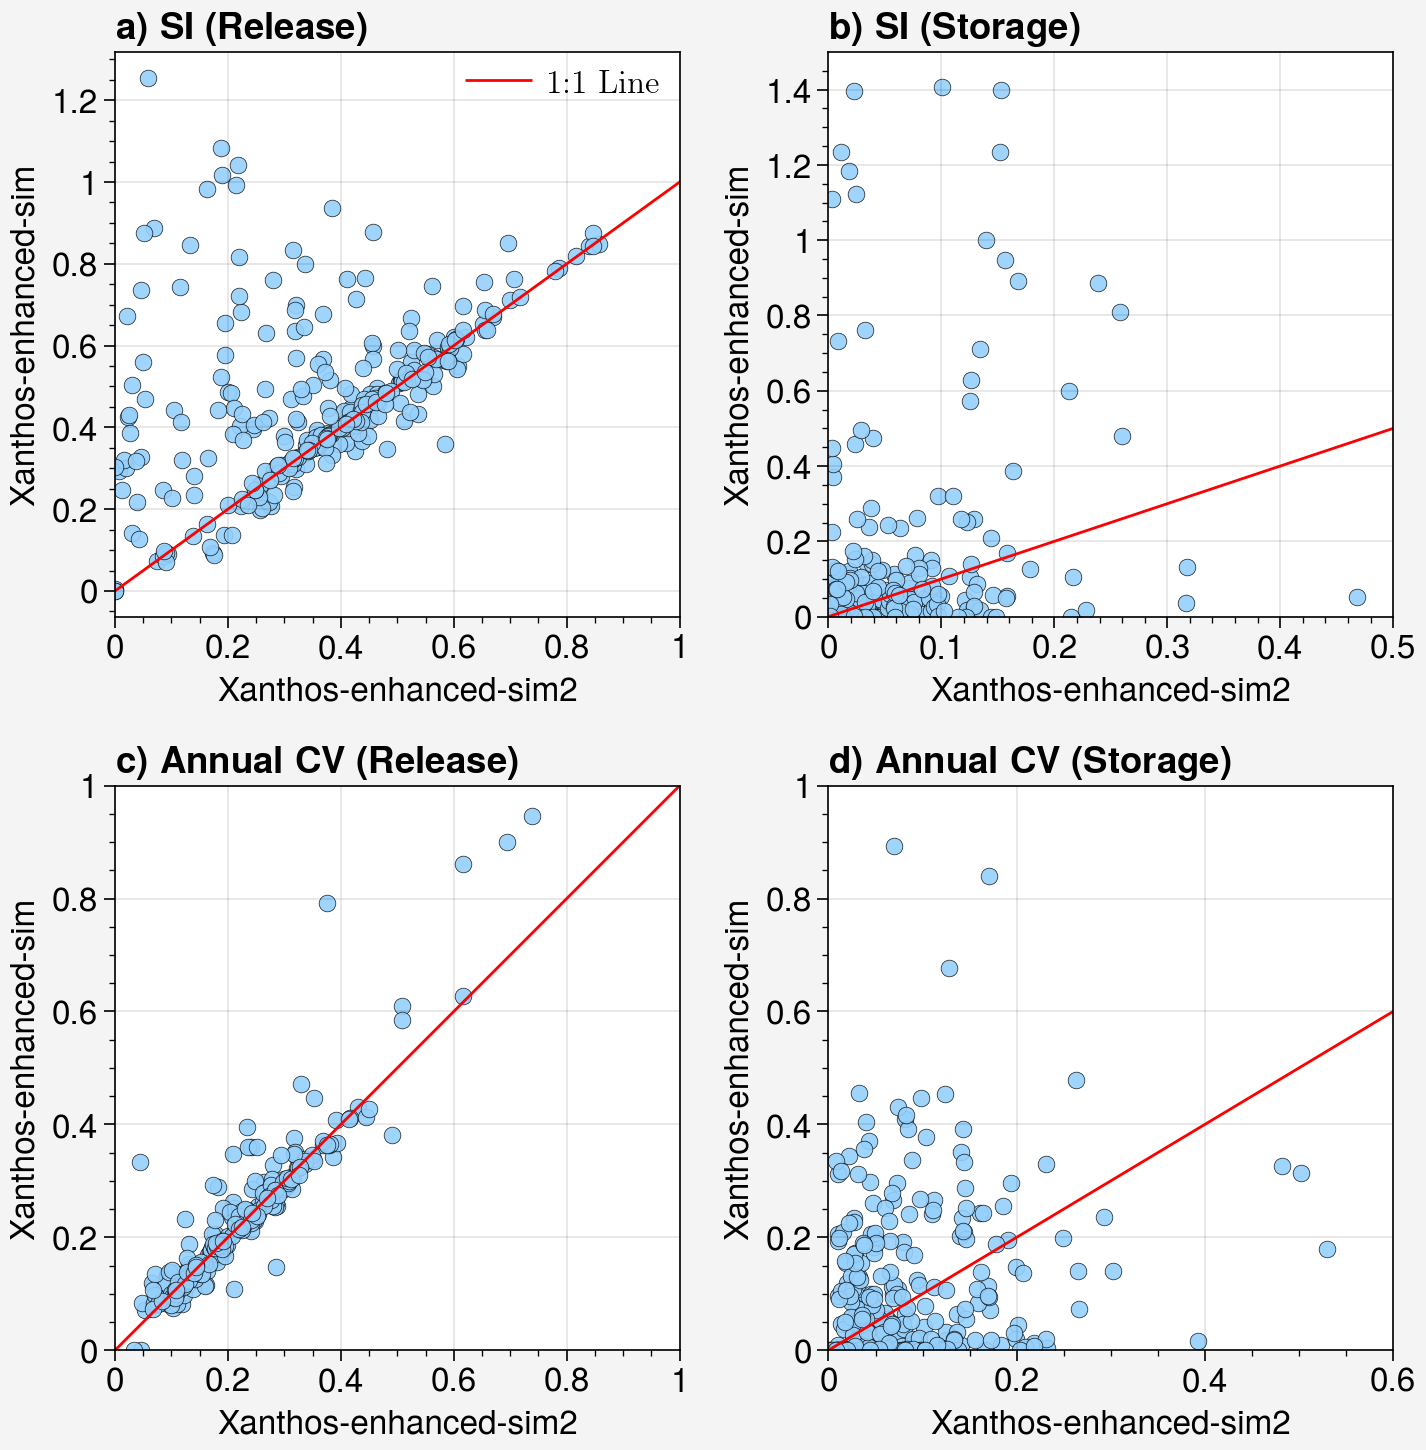

In [8]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12, 'font.weight':'bold'}) 


#plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'

## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}
#import matplotlib.pyplot as plt
#cm = plt.cm.get_cmap('RdYlBu')

basin_235_xanthos = gpd.read_file(dir_in + '/basin_235_xanthos/basin_harmed.shp')
basin_235_xanthos['dx'] = 1

fig, axes = pplt.subplots(nrows=2, ncols=2, share=0, journal='nat2')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        ########## KGE
        ax = axes[0]
        cycle = pplt.Cycle('dark blue', space='hpl', N=12)
        ax.scatter(nrmse_hpfc_all_release['SIQfc'], 
                   nrmse_hpfc_all_release['SIQhp'], 
                   color='light blue', alpha=0.9, edgecolor='k', linewidth=0.25, label='')
        ax.plot([0,1.0], [0, 1.0], 'r', label= '1:1 Line')
        ax.format(xlabel='Xanthos-enhanced-sim2')
        ax.format(ylabel='Xanthos-enhanced-sim')
        ax.format(abc=True, abcstyle=r'$\bf{{{a)}}}$', title=r'$\bf{{{SI\ (Release)}}}$', titleloc='l', fontweight='bold')
        ax.legend(loc='ur')
        ax = axes[1]
        ax.scatter(nrmse_hpfc_all_storage['SIRfc'], 
                   nrmse_hpfc_all_storage['SIRhp'], color='light blue', alpha=0.9, edgecolor='k', linewidth=0.25)
        ax.plot([0,1.5], [0, 1.5], 'r')
        ax.set_xlim([0,0.5])
        ax.set_ylim([0,1.5])        
        ax.format(xlabel='Xanthos-enhanced-sim2')
        ax.format(ylabel='Xanthos-enhanced-sim')
        ax.format(abc=True, abcstyle=r'$\bf{{{a)}}}$', title=r'$\bf{{{SI\ (Storage)}}}$', titleloc='l', fontweight='bold')
        #ax.set_title(r'$\bf{{{b) SI (Storage)}}}$', loc='left')
        #g2.set_title(r'$\bf{{{b) Parameters\ Sensitivity
        ########## KGE
        ax = axes[2]
        ax.scatter(nrmse_hpfc_all_release['CVQfc'], 
                   nrmse_hpfc_all_release['CVQhp'], color='light blue', alpha=0.9, edgecolor='k', linewidth=0.25)
        ax.plot([0,1.5], [0, 1.5], 'r')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.format(xlabel='Xanthos-enhanced-sim2')
        ax.format(ylabel='Xanthos-enhanced-sim')
        ax.format(abc=True, abcstyle=r'$\bf{{{a)}}}$', title=r'$\bf{{{Annual\ CV\ (Release)}}}$', titleloc='l', fontweight='bold')

        ax = axes[3]
        ax.scatter(nrmse_hpfc_all_storage['CVRfc'], 
                   nrmse_hpfc_all_storage['CVRhp'], color='light blue', alpha=0.9, edgecolor='k', linewidth=0.25)
        ax.plot([0,5], [0, 5], 'r')
        ax.set_xlim([0,0.6])
        ax.set_ylim([0, 1])
        ax.format(xlabel='Xanthos-enhanced-sim2')
        ax.format(ylabel='Xanthos-enhanced-sim')
        ax.format(abc=True, abcstyle=r'$\bf{{{a)}}}$', title=r'$\bf{{{Annual\ CV\ (Storage)}}}$', titleloc='l')

fig.align_ylabels(axes)
plt.tight_layout()

dir_out = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\Manuscript-09072022\\Figures-Updated\\'
plt.savefig(dir_out + "Figure-7-Seasonality-HP-vs-FC.png", **SAVE_KWDS)      
